In [814]:
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib


import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
#scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xlrd
from sklearn.preprocessing import Imputer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection #might be model_selection <--- this is the new one
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
import seaborn as sns
import xgboost as xgb
sns.set_style("whitegrid")
%matplotlib inline

scipy: 0.19.1
numpy: 1.12.1
matplotlib: 2.0.2
pandas: 0.20.3
sklearn: 0.19.0


In [815]:
pd.set_option("display.max_columns",500)

In [816]:
data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2016_Registrants_No_Minors.csv', header = 2)


In [817]:
test_data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2017_Registrants_No_Minors.csv', header = 2)

In [818]:
def dups_with_dif_index_check(data):
    dupes = {}                        # checks to see if duplicated columns with different index values
    for col_a in data.columns:
        dupes[col_a] = []

        for col_b in data.columns:
            if col_b in dupes.keys():
                continue
            if (data.loc[:,col_a] == data.loc[:,col_b]).sum() == len(data.loc[:,col_a]):
                dupes[col_a].append(col_b)    
   
    bad_cols = []   
    for col, dup_cols in dupes.iteritems():
        bad_cols += dup_cols
    bad_cols = set(bad_cols)

    data = data.loc[:,~data.columns.isin(bad_cols)]
    return data

In [819]:
def clear_dups_na(data):
    data = data.loc[:,~data.columns.duplicated()] 
    data = data.dropna(axis=1, how='all')
    data = data.dropna(axis=0, how='all')
    data = dups_with_dif_index_check(data)
    return data

In [820]:
def data_drop_other_text(data):
    col = []
    for a in data:
        if "_text" in a or "_other" in a:
            col.append(a)
    data=data.drop(labels = col, axis =1)
    return data

In [821]:
def get_rid_of_nonnumerical_answer(data):
    col = [] # THIS NEEDS TO BE CHANGED FOR NEW DATA SET
    checker = 1
    for a in data.columns:
        if '_codes' in a and checker ==1:
            checker = 0
        if '_codes' not in a and checker == 0:
            col.append(a)
    data = data.drop(col, axis = 1)
    return data

In [822]:
def answers_dummies(data):
    column =[]
    for a in data.columns:
        if "_codes" in a:
            column.append(a)  
    for a in column:
        new_data = data[a].str.get_dummies(sep=',')
        data = pd.concat([data, new_data], axis=1)
        data = data.drop([a], axis = 1)
    return data
    

In [823]:
def data_change_string_drop_dups(data):
    for a in data.columns:
        if data[a].dtype== np.dtype('O'):
            data[a] = data[a].astype('S32')
    cols = list(data)    # THIS DROPS ALL COLUMNS THAT HAVE THE SAME VALUE
    nunique = data.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    data = data.drop(cols_to_drop, axis=1)
    return data

In [824]:
def purchase_dummies(data):
    new_data = data['PurchaseItems'].str.get_dummies(sep=',')
    data = pd.concat([data, new_data], axis=1)
    data = data.drop(['PurchaseItems'], axis = 1)
    return data 

In [825]:
def state_dummies(data):
    s = data.State.value_counts()
    s = data.State.value_counts()[s > (len(data)/2031.265)].index #8
    holder = pd.get_dummies(data.State)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [826]:
def email_change(data):
    for index, row in data.iterrows():
        data.loc[index, 'Email'] = data['Email'][index].split("@",1)[1]
    return data

In [827]:
def email_dummies(data):
    data = email_change(data)
    s = data.Email.value_counts()
    s = data.Email.value_counts()[s > (len(data)/338.6)].index  #48
    holder = pd.get_dummies(data.Email)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [828]:
def column_drops(data):
    data = data.drop(['WebUrl',"CheckInDate Date","Aux1", "Aux5","FirstPrintDate Time","FirstPrintLocId", 'FirstPrintStationId','CheckInDate Time',"ModifyDate Time", "IndexDate"], axis = 1)
    data = data.drop(['RegTypeDesc','SourceApp','CountryName','StreamSteps','StreamName', 'RegType','StreamStep',"AddUserId","ModifyUserId","AddDate Date","AddDate Time","ModifyDate Date"], axis = 1)
    data = data.drop(["Pwd", "UserName", "AccountKeyPublic","AccountKeyPrivate", "Notes",'Id', 'AccountId', 'ClientIp', 'StreamId','State', 'StreamStatus'], axis = 1)
    return data

In [829]:
def data_dummies(data):
    data = pd.get_dummies(data,columns = ['Aux6', 'ApprovalUserId', 'LangId', 'MemberStatus', 'TermsAccepted'], dummy_na = True)
    return data
    

In [830]:
def data_dummies_cleanup(data):
    d = {'3001': ['3001', '3001.1']}   
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'2001': ['2001', '2001.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    # renames duplicate column names
    d = {'TermsAccepted_nan': ['TermsAccepted_nan', 'TermsAccepted_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'MemberStatus_nan': ['MemberStatus_nan', 'MemberStatus_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    return data

In [831]:
def processing_data(data):
    data = data.apply(pd.to_numeric, errors='ignore')
    data = clear_dups_na(data)
    data = data_drop_other_text(data)
    data = get_rid_of_nonnumerical_answer(data)
    data = answers_dummies(data)
    data = data_change_string_drop_dups(data)
    data = purchase_dummies(data)
    data = state_dummies(data)
    data = email_dummies(data)
    data = column_drops(data)
    data = data_dummies(data)
    data = data_dummies_cleanup(data)
    return data

In [832]:
data = processing_data(data)

In [833]:
data.to_pickle("Data_Zoo.pkl")

In [834]:
data = pd.read_pickle("Data_Zoo.pkl")

In [835]:
test_data = processing_data(test_data)

In [836]:
test_data.to_pickle("Data_Zoo_test.pkl")

In [837]:
test_data = pd.read_pickle("Data_Zoo_test.pkl")

In [743]:
test_data.shape

(9719, 363)

In [573]:
#(data.T.drop_duplicates(subset=data.index)).T  # to big of a dataset to use this to get rid of duplicate columns with different names

In [585]:
#for a in range(0,len(data.columns)):                                          # look at values of columns
#    if len(data.iloc[:,1])-data.iloc[:,a].isnull().sum() == 0:
#         print data.columns[a], len(data.iloc[:,1])-data.iloc[:,a].isnull().sum()

In [794]:
data.shape

(16253, 361)

In [838]:
def y_for_train(test_data):
    y =[]
    for a in data['FirstPrintDate Date']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [845]:
def y_for_test(test_data):
    y =[]
    for a in test_data['FirstPrintDate']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [840]:
def train_test_column_sync(data, test_data):
    col=[]
    for a in data.columns:
        checker = 0 
        for b in test_data.columns:
            if a == b:
                checker = 1
        if checker == 1:
            col.append(a)
    return col

In [841]:
def data_impute(X):
    data_X_hold = X.columns
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    imp.fit(X)
    data_T=imp.transform(X)
    X = pd.DataFrame(data_T, columns = data_X_hold)
    return X

In [846]:
def train_test_processing(data, test_data):
    train_Y = y_for_train(test_data)
    test_Y = y_for_test(test_data)
    col = train_test_column_sync(data, test_data)
    train_X = data[col]
    test_X = test_data[col]
    train_X = train_X.select_dtypes(include = ['int64', 'float64', 'uint8']).iloc[:, 1:]
    test_X = test_X= data.select_dtypes(include = ['int64', 'float64', 'uint8']).iloc[:, 1:]
    train_X = data_impute(train_X)
    test_X = data_impute(test_X)
    return (train_X, train_Y, test_X, test_Y)

In [847]:
train_X, train_Y, test_X, test_Y = train_test_processing(data, test_data)

In [849]:
num_folds = 10
num_instances = len(train_X) 
seed = 7
scoring = 'roc_auc'

In [850]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(random_state = seed))) 
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, train_X, train_Y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.530117 (0.009862)
NB: 0.487746 (0.010805)
CART: 0.664645 (0.014057)
KNeighborsClassifier: 0.663643 (0.007986)
XGBClassifier: 0.727727 (0.011577)
GradientBoostingClassifier: 0.728937 (0.012972)
AdaBoostClassifier: 0.719137 (0.009861)
RandomForestClassifier: 0.723287 (0.016215)
ExtraTreesClassifier: 0.707873 (0.013152)
DecisionTreeClassifier: 0.664645 (0.014057)


In [ ]:
model = xgb.XGBClassifier()
    model.fit(X, y)
    #test_preds = model.predict(test_X)
    test_preds = model.roc_auc(test_X,test_y)
    return test_preds

In [459]:
estimator =  RandomForestClassifier(random_state = seed)
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(X,y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 256
Feature Ranking: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 37 64 55 58  1  1 83 49 36  1 45  1  1  1  1  1
 35  1  1 16 39 74  1 60 70  1 79 67  7 89 88 34  1  1 73 44 81 78 72 56  1
  1  1  1 22 61  1  1 12  1  6 52 82  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 51  1  1  1  1  1  1  1
  1  1  1  1  1 63  1 59  1  1  1  1  1  1 76  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  3  1  1 17 19 30 27 33  1 86 77  1 91  1 66
 14 11  1 53  1 10  1 50  1 23 62  1 43 57  2 75 18  1 38  1  1 85 26  1  5
  1  1 15 65 13  9 84 48 87 40 25  1 32 69 21  1 68 31 80 47 54  1 46  1 90
  1  1  1  1  1  1  1  1  8  1 71  4  1 42  1 20  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 24  1  1 28  1
  1  1 29  1  1 41  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [460]:
top_256_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_256_important_features.append(b)
        print b,X.columns[b]

0 Phone2CountryPrefix
1 Phone2Number
2 FaxCountryPrefix
3 AmountBilled
4 AmountPaid
5 AmountDue
6 0201
7 0202
8 0203
9 0204
10 0205
11 0206
12 0207
13 0208
14 0209
15 0210
16 0211
17 0212
18 0213
19 0214
20 0215
21 0216
22 0217
23 0218
24 0219
25 0220
26 0221
27 0222
28 0223
29 0224
30 0225
31 0226
32 0227
33 0401
38 0602
39 0701
43 1201
45 1301
46 1401
47 1501
48 1601
49 1801
51 1902
52 2001
56 2203
59 2304
66 2403
67 2501
74 3103
75 3104
76 3201
77 3301
80 3601
81 3801
83 3901
87 4101
88 4301
89 4302
90 4303
91 4304
92 4305
93 4306
94 4310
95 4311
96 4312
97 4313
98 4314
99 4315
100 4316
101 4317
102 4318
103 4319
104 4321
105 4322
106 4323
107 4324
108 4325
109 4326
110 4327
111 4329
112 4330
113 4331
114 4332
115 4333
116 4336
118 4338
119 4339
120 4340
121 4341
122 4346
123 4347
124 4348
125 4351
126 4352
127 4401
128 4501
129 4502
131 4801
133 5001
134 5002
135 1001
136 1002
137 1003
138 1004
140 1006
141 1007
142 1008
143 1009
144 1010
145 1011
146 1012
147 1013
148 1014
149 101

In [461]:
new_X = X.iloc[:,top_256_important_features]

In [462]:
X = new_X

In [463]:
top_256 = X

In [464]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(random_state = seed))) 
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.530897 (0.010641)
NB: 0.485902 (0.012623)
CART: 0.679329 (0.011278)
KNeighborsClassifier: 0.662301 (0.012062)
XGBClassifier: 0.730652 (0.010398)
GradientBoostingClassifier: 0.731712 (0.012840)
AdaBoostClassifier: 0.723179 (0.011872)
RandomForestClassifier: 0.736132 (0.009627)
ExtraTreesClassifier: 0.721861 (0.013679)
DecisionTreeClassifier: 0.679329 (0.011278)


In [480]:
y_test = pd.DataFrame({'y': y})

In [481]:
Z=[]
Z=pd.concat([new_X4,y_test],axis=1)

In [482]:
corr = Z.select_dtypes(include = ['int64', 'float64','uint8']).iloc[:, 1:].corr()

In [485]:
corr = corr.drop(['São Paulo'], axis = 1)

In [488]:
corr = corr.drop(['São Paulo'], axis = 0)

In [489]:
corr

,Phone2Number,FaxCountryPrefix,AmountBilled,AmountPaid,AmountDue,0201,0202,0203,0204,0205,0206,0207,0208,0209,0210,0211,0212,0213,0214,0215,0216,0217,0218,0219,0220,0221,0222,0223,0224,0225,0226,0227,1201,1301,1501,1601,1801,2203,2304,4301,4302,4303,4304,4305,4306,4310,4311,4312,4313,4314,...,MO,OH,NJ,BC,ON,MI,WI,TN,AB,HI,MN,PA,GA,MA,NC,KS,IN,VA,ID,NM,MD,CT,OK,QC,KY,AR,AL,NE,MT,IA,WY,RI,SK,LA,Aichi,AK,MB,NSW,NH,DE,PR,Baja California,DC,ME,ND,VT,Tokyo,SD,MS,y
Phone2Number,1.000000,0.707067,-0.002895,-0.002677,-0.001040,0.022925,0.026572,0.026696,0.019516,0.019002,0.009321,0.008050,0.005683,0.004181,-0.002454,-0.002580,0.013471,-0.004085,0.023718,0.009991,0.010299,0.026014,0.024456,0.019338,0.018335,-0.002482,-0.002615,-0.002437,-0.001948,-0.002980,-0.002148,0.023085,-0.001109,-0.001114,-0.001114,-0.000816,-0.000738,-0.000664,-0.000773,0.031601,-0.002311,-0.001653,-0.000713,-0.000910,-0.000940,-0.000245,-0.000851,-0.001436,-0.001677,-0.001178,...,-0.001273,-0.001164,-0.001204,-0.001112,-0.001133,-0.001033,-0.001011,-0.001006,-0.000983,-0.000916,-0.000941,-0.000991,-0.000844,-0.000931,-0.000882,-0.000868,-0.000903,-0.000807,-0.000818,-0.000695,-0.000735,-0.000709,-0.000588,-0.000617,-0.000642,-0.000595,-0.000680,-0.000662,-0.000568,-0.000565,-0.000571,-0.000537,-0.000470,-0.000425,-0.000514,-0.000460,-0.000459,-0.000477,-0.000426,-0.000438,-0.000409,0.000436,-0.000397,-0.000377,-0.000320,-0.000345,-0.000333,-0.000263,-0.000262,0.008130
FaxCountryPrefix,0.707067,1.000000,-0.002205,-0.002024,-0.000819,-0.002077,-0.001815,-0.001807,-0.002397,-0.002453,-0.004224,-0.004617,-0.005541,-0.006298,-0.002013,-0.002123,-0.003255,-0.003461,-0.002016,-0.004046,-0.003963,-0.001851,-0.001958,-0.002415,-0.002528,-0.002057,-0.002188,-0.002106,-0.001618,-0.002468,-0.001754,-0.002065,-0.000866,-0.000869,-0.000869,-0.000666,-0.000610,-0.000488,-0.000599,-0.001542,-0.001893,-0.001403,-0.000600,-0.000712,-0.000797,-0.000188,-0.000727,-0.001444,-0.001399,-0.000971,...,-0.000921,-0.000825,-0.000868,-0.000814,-0.000806,-0.000728,-0.000718,-0.000737,-0.000703,-0.000661,-0.000713,-0.000709,-0.000650,-0.000686,-0.000626,-0.000609,-0.000644,-0.000575,-0.000573,-0.000461,-0.000516,-0.000507,-0.000399,-0.000483,-0.000454,-0.000439,-0.000481,-0.000463,-0.000394,-0.000409,-0.000400,-0.000402,-0.000318,-0.000307,-0.000362,-0.000331,-0.000327,-0.000340,-0.000311,-0.000311,-0.000281,-0.000255,-0.000284,-0.000271,-0.000217,-0.000249,-0.000246,-0.000185,-0.000188,0.005756
AmountBilled,-0.002895,-0.002205,1.000000,0.872598,0.454030,-0.002615,0.006495,-0.001445,-0.014457,-0.003790,0.038971,0.026897,0.087880,0.089743,0.007546,0.009212,0.044202,0.237022,0.030673,0.060995,0.063399,-0.006202,-0.000079,0.005347,0.010668,0.142096,0.145099,0.178703,0.108835,0.202468,0.005669,0.065798,0.222315,0.222782,0.222782,0.167039,0.145378,0.086178,0.139944,-0.003546,0.005020,0.060652,-0.007848,0.004437,0.038709,-0.005516,0.076840,0.151871,0.099708,0.108057,...,0.026031,-0.001174,-0.015050,0.017517,-0.007703,-0.001745,-0.010073,-0.009845,0.051726,0.008458,0.027290,-0.009437,-0.010993,-0.010949,-0.006903,-0.001220,-0.001570,-0.004176,0.014777,0.005164,-0.008033,-0.011258,0.019640,-0.009207,-0.004433,-0.003459,0.006235,0.021477,0.049659,0.000478,0.010971,-0.004564,0.046089,0.030191,-0.010638,0.028209,0.030153,-0.008273,0.032441,-0.008351,0.015780,0.013452,-0.004641,0.006714,0.030472,-0.005255,0.000964,0.028883,0.010396,0.082301
AmountPaid,-0.002677,-0.002024,0.872598,1.000000,-0.039007,-0.001166,0.007347,-0.001627,-0.010107,-0.003402,0.045860,0.031195,0.091087,0.089659,0.009246,0.012634,0.052296,0.226314,0.036593,0.061062,0.066519,-0.001758,0.003560,0.014207,0.020649,0.130887,0.137880,0.162238,0.104285,0.184378,0.012646,0.073747,0.253078,0.252161,0.252161,0.189736,0.171799,0.085855,0.151107,-0.002209,0.014870,0.062018,-0.005769,0.007477,0.035510,-0.005121,0.055293,0.152096,0.085848,0.103069,...,0.029192,-0.001578,-0.013906,0.021503,-0.006968,-0.016924,-0.007194,-0.006976,0.056927,0.013915,0

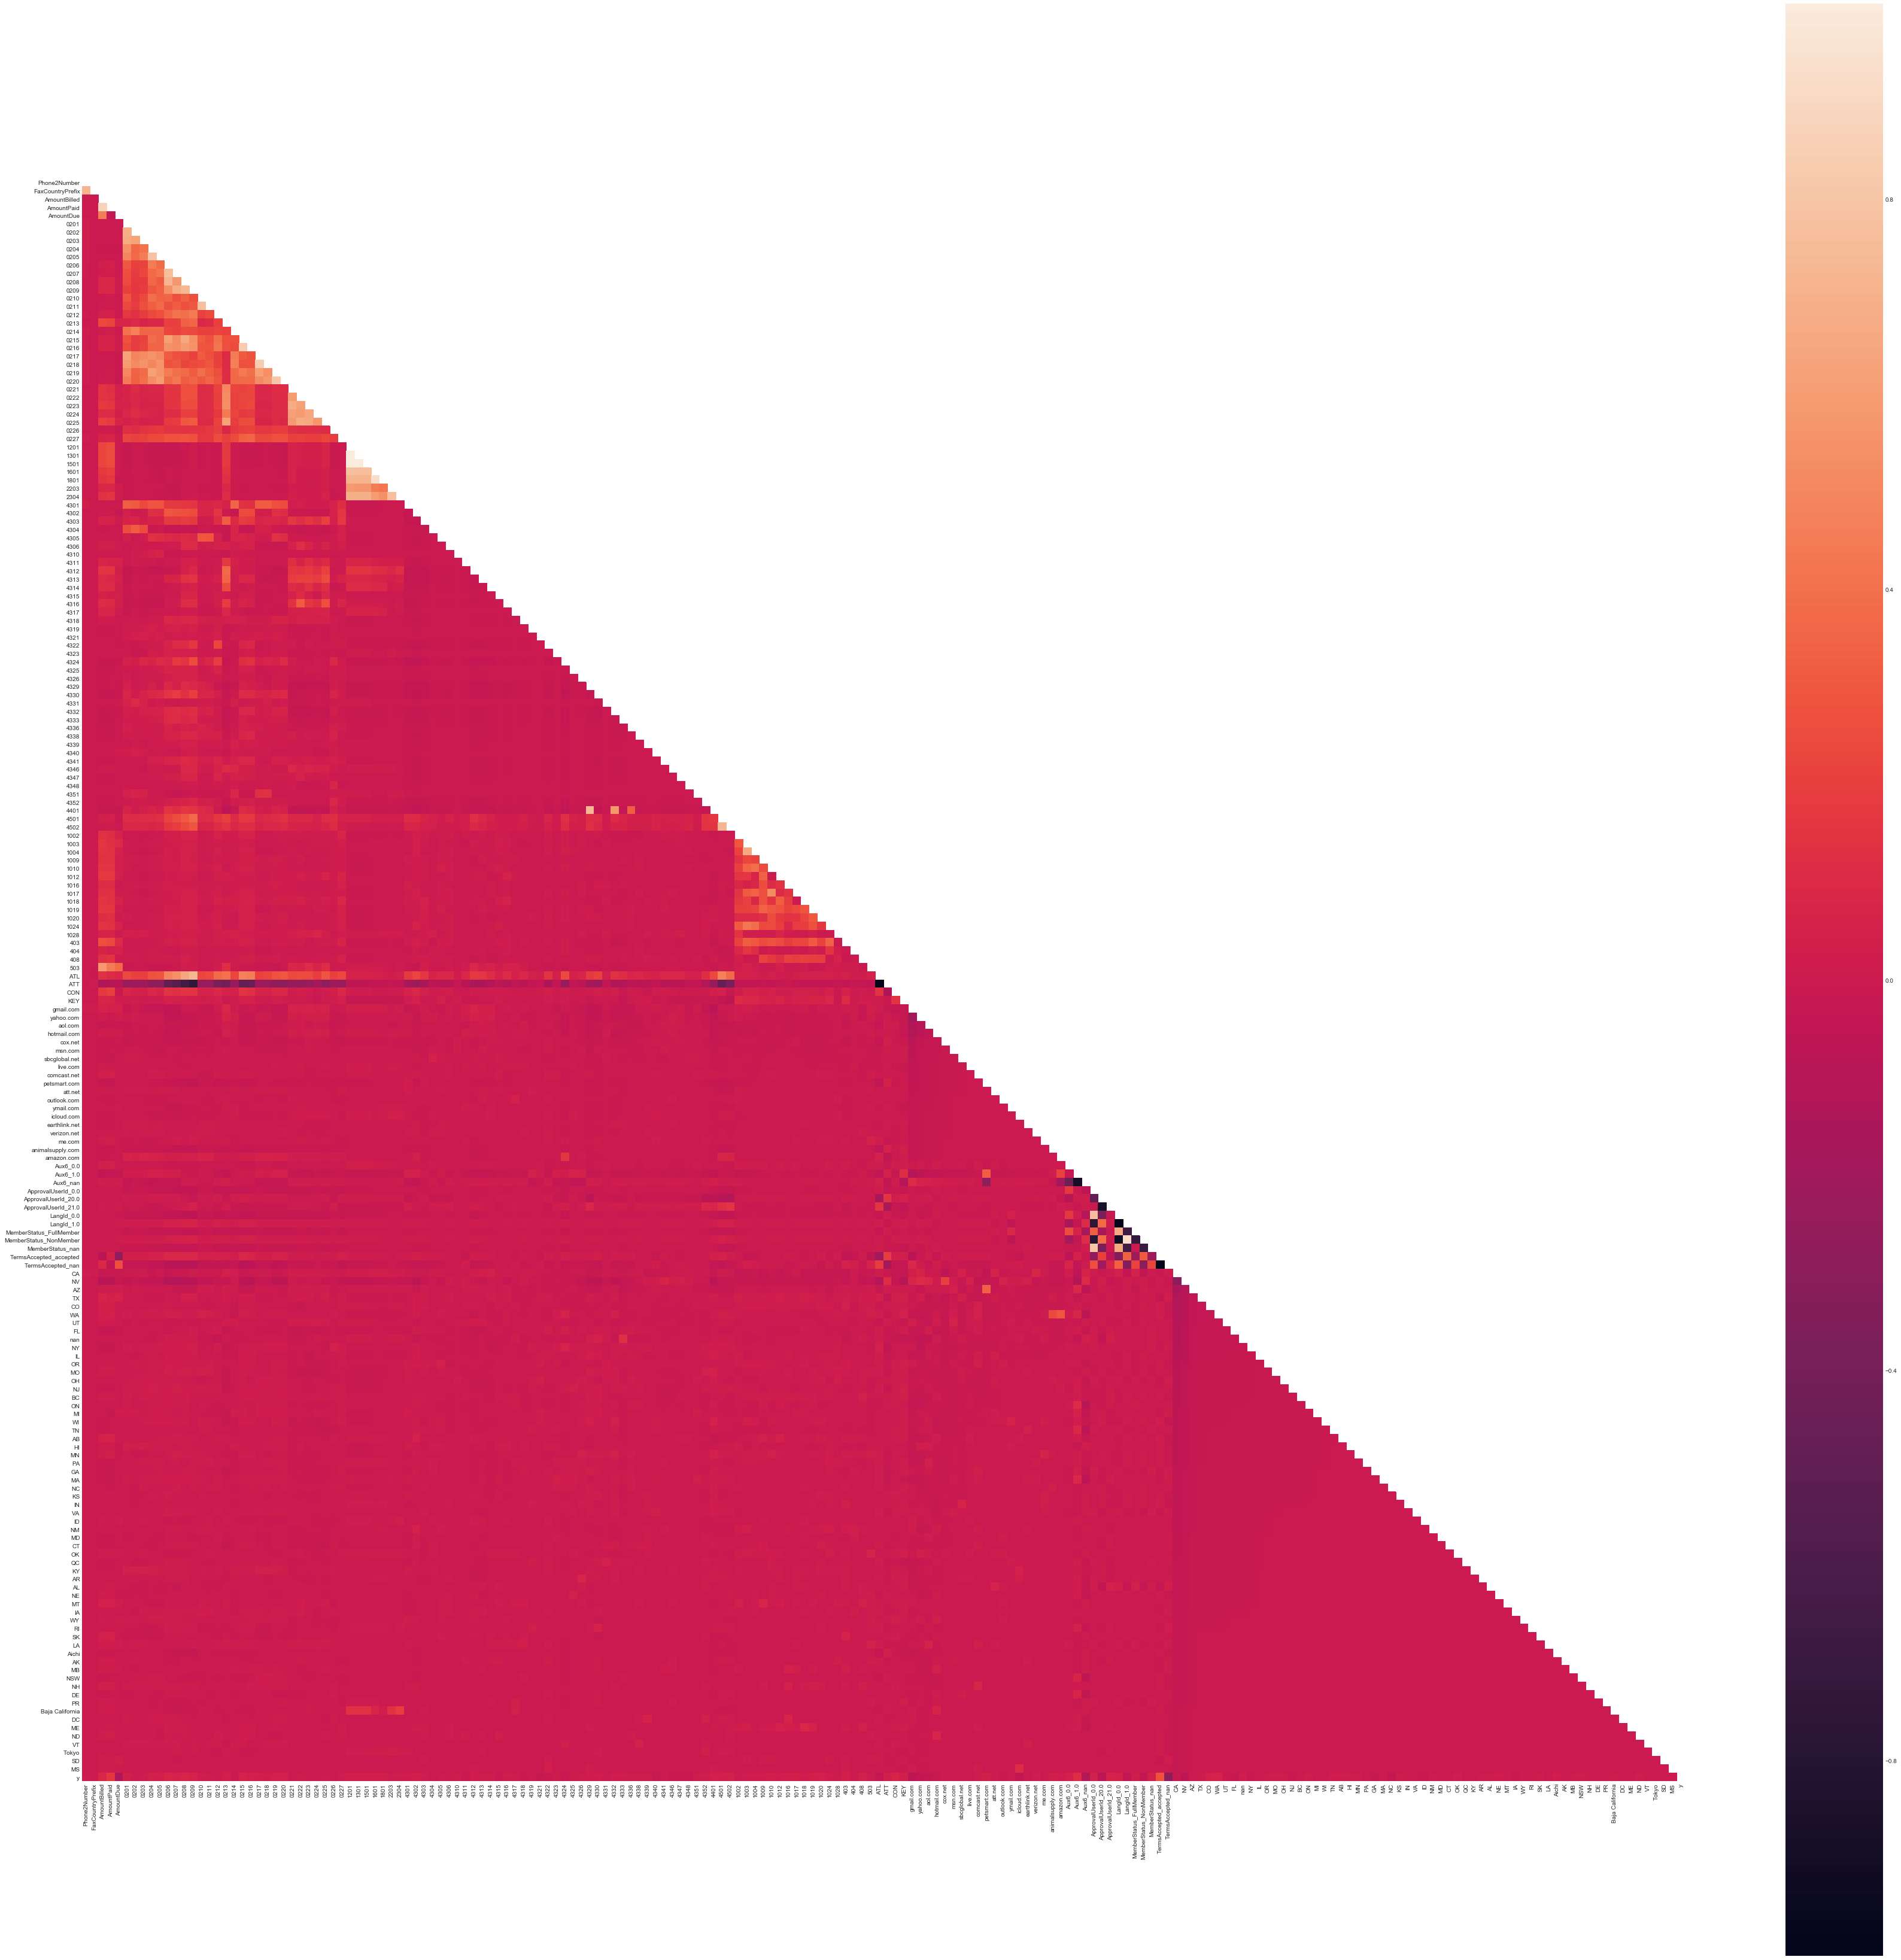

In [490]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(60, 60))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin = -1, vmax=1, square=True)

In [469]:
estimator = RandomForestClassifier(random_state = seed)
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(X,y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 195
Feature Ranking: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 18 62  7  1  1 13  1  1  1 14 53  1  1 10 58 25 32
  8 51 47 11 44 49  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  6  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 27 20 21
 28  1  1  1 17 33  5  1  1 40  1 26 41  9  1  1  1  1  1 19 24 15  1 52 55
  1 59 45 35 34 16 56 61 12 57 38 46 60 54 50 36 39 23 48 37 30  1  1 29 22
 42  1  1 43 31  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  1  1  1  1
  1  1  1  3  2  1]


In [473]:
top_195_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_195_important_features.append(b)
        print b,X.columns[b]

0 Phone2CountryPrefix
1 Phone2Number
2 FaxCountryPrefix
3 AmountBilled
4 AmountPaid
5 AmountDue
6 0201
7 0202
8 0203
9 0204
10 0205
11 0206
12 0207
13 0208
14 0209
15 0210
16 0211
17 0212
18 0213
19 0214
20 0215
21 0216
22 0217
23 0218
24 0219
25 0220
26 0221
27 0222
28 0223
29 0224
30 0225
31 0226
32 0227
36 1201
37 1301
39 1501
40 1601
41 1801
44 2203
45 2304
56 4301
57 4302
58 4303
59 4304
60 4305
61 4306
62 4310
63 4311
64 4312
65 4313
66 4314
67 4315
68 4316
69 4317
70 4318
71 4319
72 4321
73 4322
74 4323
75 4324
76 4325
77 4326
79 4329
80 4330
81 4331
82 4332
83 4333
84 4336
85 4338
86 4339
87 4340
88 4341
89 4346
90 4347
91 4348
92 4351
93 4352
94 4401
95 4501
96 4502
101 1002
102 1003
103 1004
107 1009
108 1010
110 1012
114 1016
115 1017
116 1018
117 1019
118 1020
122 1024
125 1028
146 403
147 404
151 408
152 503
155 ATL
156 ATT
157 CON
158 KEY
159 gmail.com
160 yahoo.com
161 aol.com
162 hotmail.com
163 cox.net
164 msn.com
165 sbcglobal.net
166 live.com
167 comcast.net
168 pets

In [474]:
new_X4 = X.iloc[:,top_195_important_features]

In [475]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(random_state = seed))) 
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, new_X4, y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.530897 (0.010641)
NB: 0.485691 (0.012826)
CART: 0.678888 (0.009882)
KNeighborsClassifier: 0.662328 (0.012162)
XGBClassifier: 0.730619 (0.011730)
GradientBoostingClassifier: 0.731960 (0.012021)
AdaBoostClassifier: 0.722742 (0.012789)
RandomForestClassifier: 0.734418 (0.011499)
ExtraTreesClassifier: 0.723115 (0.013773)
DecisionTreeClassifier: 0.678888 (0.009882)


In [476]:
estimator = RandomForestClassifier(random_state = seed)
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(new_X4,y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 163
Feature Ranking: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  9 19 29 11 27  1  1  1  1  1  1 30  1  1  1
  1  1  1  7  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  3  1  1  1  1  1 16 17  4 20 14 33  5 28  1  1 18  1  1 23 22 15  1  1  1
  1  1  1  1  1  1  1  1  1  1  8  1  1  1  1  1  1  1  1  1  1  1  1 12  1
  1  1  1 24  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  6  1  1 25  1 10  1 32  1  1 13  1 21 26  1 31]


In [477]:
top_163_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_163_important_features.append(b)
        print b,X.columns[b]

0 Phone2CountryPrefix
1 Phone2Number
2 FaxCountryPrefix
3 AmountBilled
4 AmountPaid
5 AmountDue
6 0201
7 0202
8 0203
9 0204
10 0205
11 0206
12 0207
13 0208
14 0209
15 0210
16 0211
17 0212
18 0213
19 0214
20 0215
21 0216
22 0217
23 0218
24 0219
25 0220
26 0221
27 0222
28 0223
29 0224
30 0225
31 0226
32 0227
33 0401
34 0602
40 1601
41 1801
42 1902
43 2001
44 2203
45 2304
47 2501
48 3103
49 3104
50 3201
51 3301
52 3601
54 3901
55 4101
57 4302
58 4303
59 4304
60 4305
61 4306
62 4310
63 4311
64 4312
65 4313
66 4314
67 4315
68 4316
69 4317
70 4318
71 4319
72 4321
73 4322
74 4323
76 4325
77 4326
78 4327
79 4329
80 4330
89 4346
90 4347
92 4351
93 4352
97 4801
98 5001
99 5002
100 1001
101 1002
102 1003
103 1004
104 1006
105 1007
106 1008
107 1009
108 1010
109 1011
111 1013
112 1014
113 1015
114 1016
115 1017
116 1018
117 1019
118 1020
119 1021
120 1022
121 1023
122 1024
124 1027
125 1028
126 2006
127 2009
129 2015
130 2017
131 2019
132 2021
133 2024
134 2030
135 2032
136 2033
137 2036
138 2038


In [478]:
new_X5 = X.iloc[:,top_163_important_features]

In [479]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(random_state = seed))) 
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, new_X5, y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.530426 (0.010997)
NB: 0.485689 (0.012825)
CART: 0.668654 (0.015519)
KNeighborsClassifier: 0.645787 (0.014444)
XGBClassifier: 0.724794 (0.010506)
GradientBoostingClassifier: 0.724134 (0.010846)
AdaBoostClassifier: 0.717335 (0.009361)
RandomForestClassifier: 0.720520 (0.009031)
ExtraTreesClassifier: 0.704930 (0.012801)
DecisionTreeClassifier: 0.668654 (0.015519)


In [313]:
y_test = pd.DataFrame({'y': y})

In [326]:
Z=[]
Z=pd.concat([new_X5,y_test],axis=1)

In [327]:
corr = Z.select_dtypes(include = ['int64', 'float64','uint8']).iloc[:, 1:].corr()

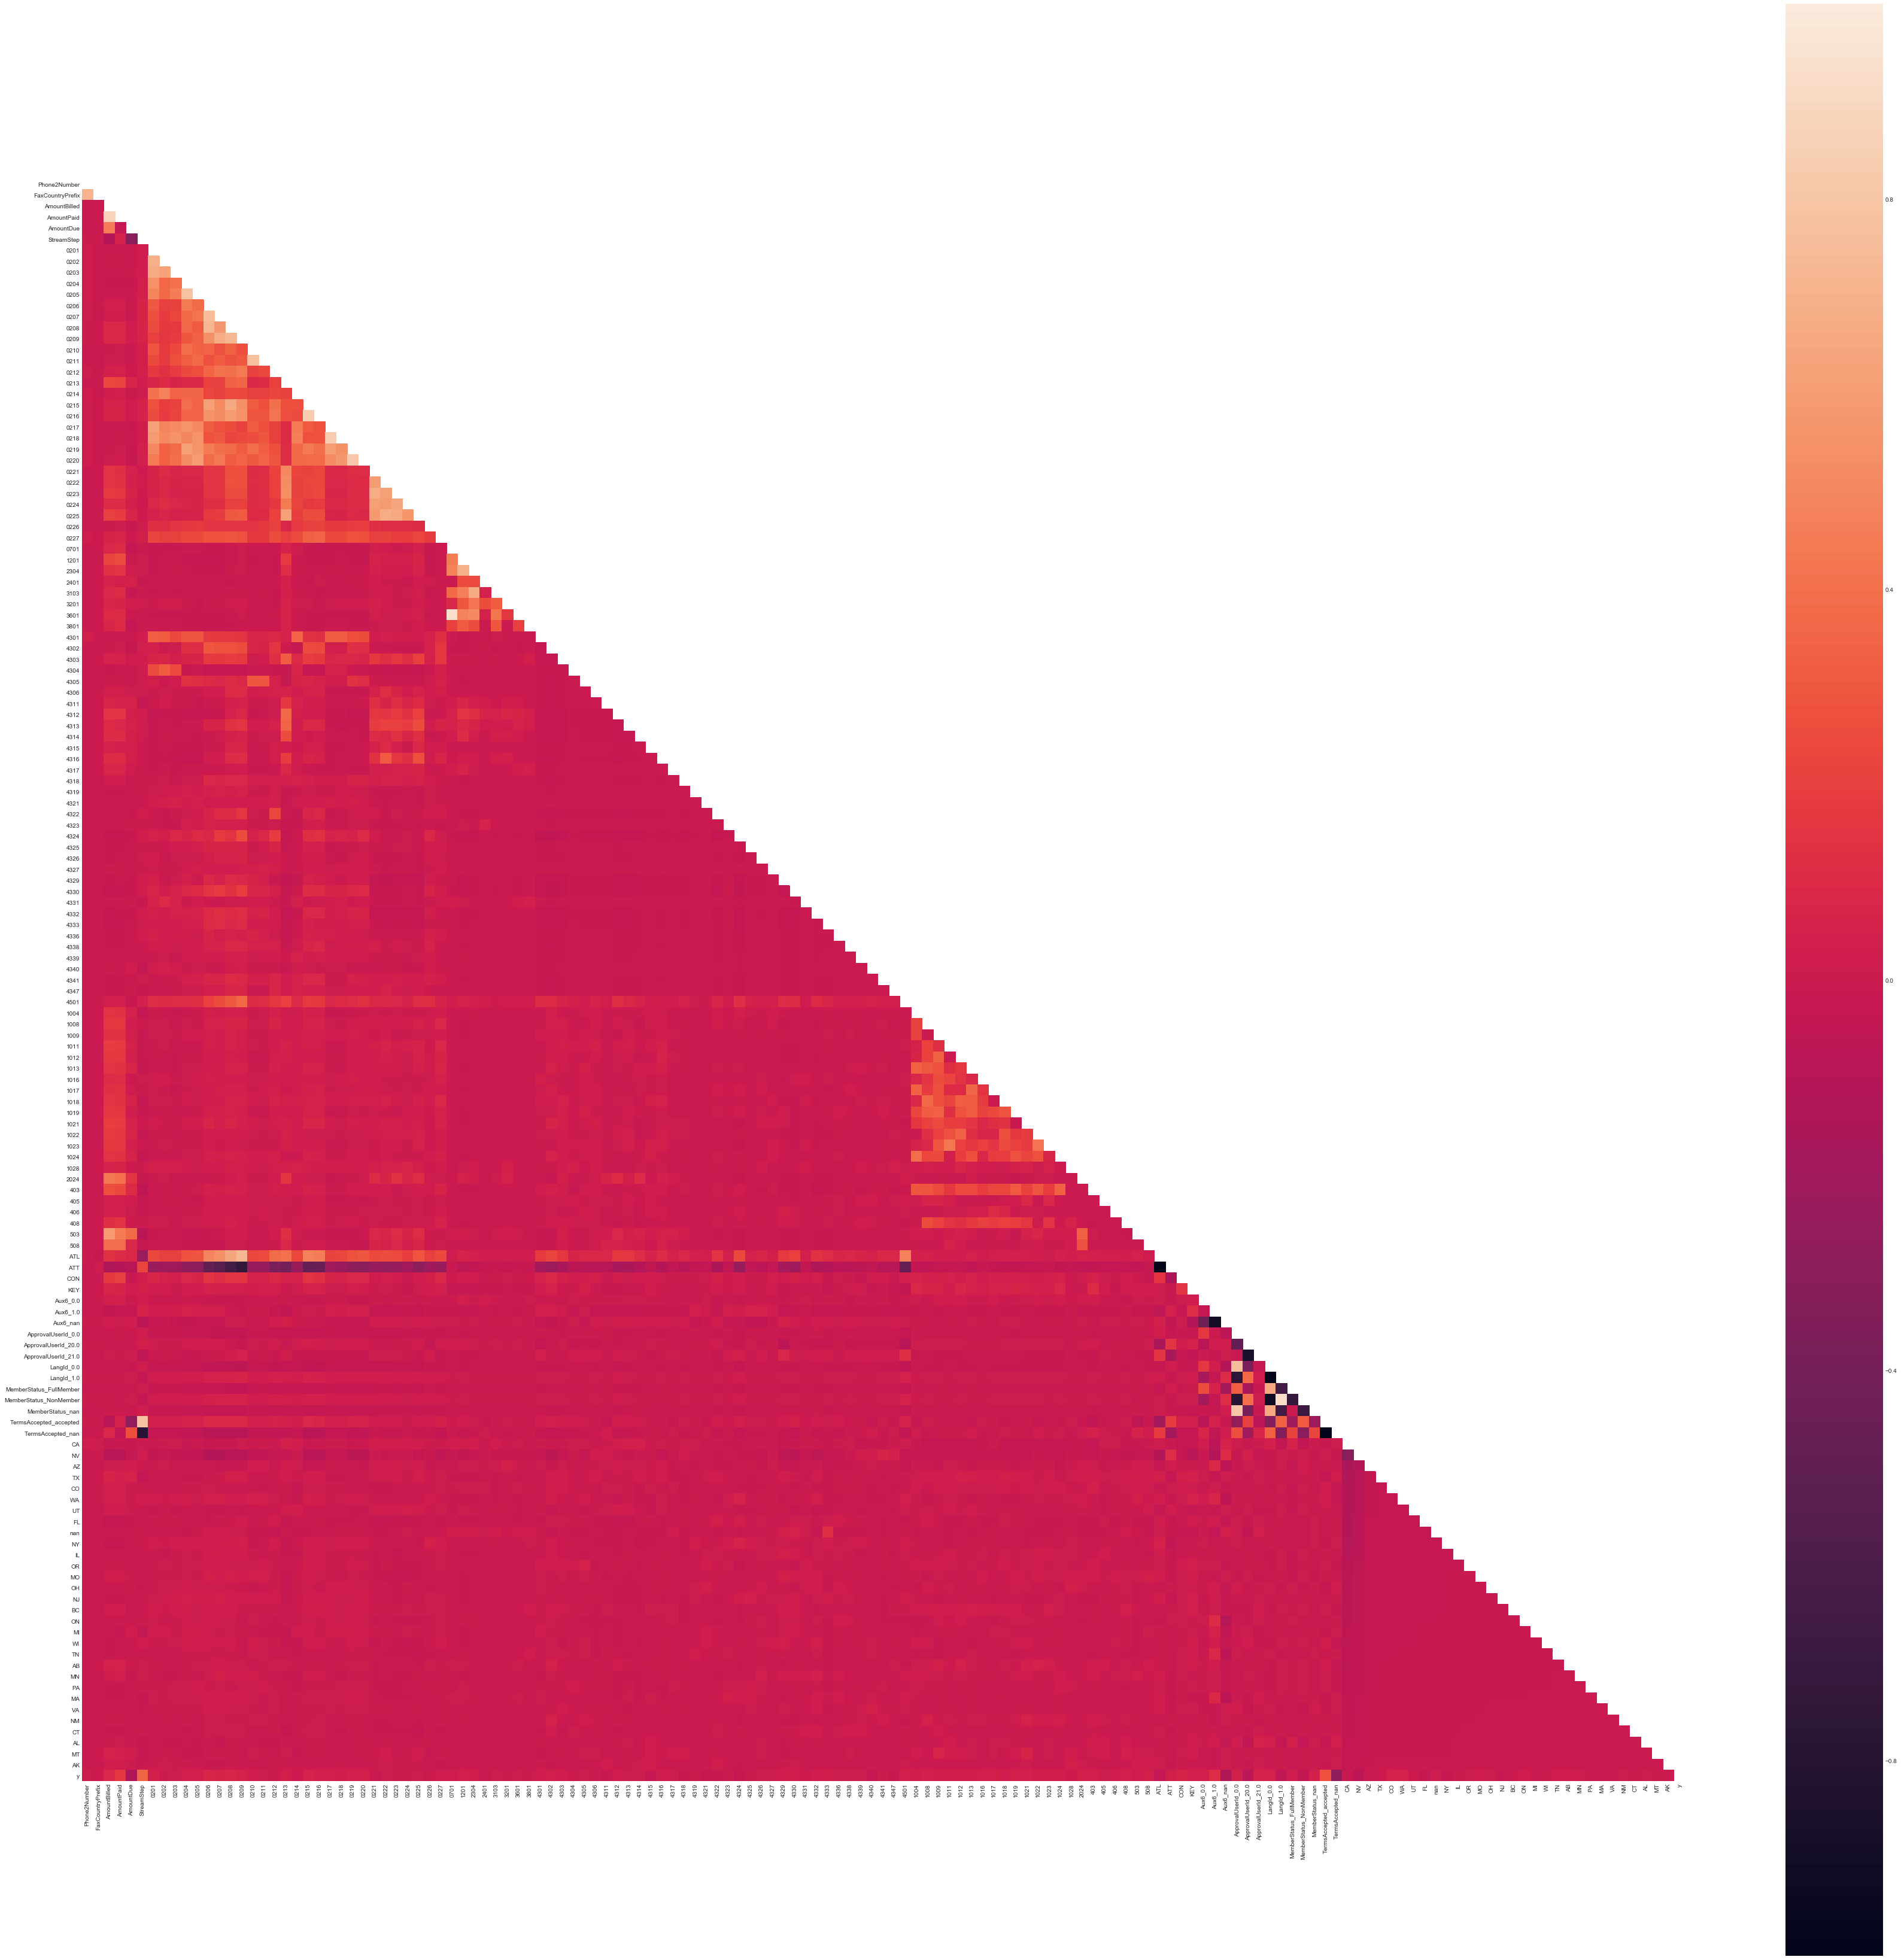

In [328]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(60, 60))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin = -1, vmax=1, square=True)

In [281]:
num_folds = 10
num_instances = len(X) 
seed = 7
scoring = None

NameError: name 'X' is not defined

In [206]:
data.Aux6.value_counts()

1.0    807
0.0    209
Name: Aux6, dtype: int64

In [112]:

pd.set_option('display.max_columns', 500)

In [ ]:
for b in range(0, len(data.columns)):
    print b, data.columns[b]